# Requirements

## Download and Extract

1. Download and extract data from https://www.kaggle.com/c/avazu-ctr-prediction
2. Ensure that file `train` is stored in `<notebook-path>/data/train`

# Import

### Import dataset


> Note!
>
> Usually I'd have invested time to refactor the code to operate on chunks, since my local environment has only 5GB left to work on. Due to lack of time I have a few options provided.
>
> I've worked upon a sampled subset of data/train with about 1000 lines
>
> If you'd like to use the whole dataset, feel free to use `ds = train` down below, or simply `ds = temp` for my sampled version if you're also lacking precious memory
>
> Use `sample_size` if you do not want to run the notebook on prefiltered random sample stored in `data/temp`, but
> prefer to randomly sample the data while reading from the dataset

In [1]:
%matplotlib notebook
%automagic 1
import matplotlib.pyplot as plt
import random
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML

data_dir = 'data'

# Needed once to find out how many rows there are for every csv we could import here, namely
#    'data/test - Rows: 4577465'
#
#    'data/train - Rows: 40428968'
#
#    'data/temp - Rows: 1001'
#for file in [Path(f'{data_dir}/{f}') for f in ['test','train','temp']]:
#    display(f'{file} - Rows: {sum(1 for line in open(file))}')


# Variable to change verbosit throughout this notebook
# Can be used to get more debugging information at every cell (if available)
verbose = False

# TODO: add automatic download function if data is not present
#       by integrating kaggle-api

train={
    'path': 'data/train',
    'rows': 40428968
}
test ={
    'path': 'data/test',
    'rows': 4577465
}
temp = {
    'path': 'data/temp',
    'rows': 1001
}

# >>>>>>>>>>>> Select dataset <<<<<<<<<<<<<<<<
dataset = temp
#dataset = train
sample_size = None
#sample_size = 4000
# >>>>>>>>>>>> Select dataset <<<<<<<<<<<<<<<<

if sample_size:
    total = dataset['rows'] # number of records in file
    # The row indices to skip - make sure 0 is not included to keep the header!
    skip = [x for x in range(1, total) if x % int(total/sample_size) != 0]
    # skip = sorted(random.sample(range(1, total), total - sample_size))
    quantity_description = f'sampled ({sample_size})' 
else:
    skip = None
    quantity_description = f'all ({dataset["rows"]})'

display(f'Importing {quantity_description} data `{dataset["path"]}`...')

# Load training set (and only the 2 columns we need right now, as my memory will not suffice otherwise)
xdf = pd.read_csv(dataset['path'], sep=',', header=0, usecols=['hour', 'click'], skiprows=skip)
#ctr_df.info()

# clean up indexes of pre-selected skipped rows, if necessary
if skip is not None:
    del skip


print(f'Imported {xdf.shape[0]} rows of \'{dataset["path"]}\'')
print(f'Head of imported dataset \'{dataset["path"]}\'')

# Sanity check of import
display(xdf.head())
verbose and xdf.info()



Automagic is ON, % prefix IS NOT needed for line magics.


'Importing all (1001) data `data/temp`...'

Imported 1000 rows of 'data/temp'
Head of imported dataset 'data/temp'


,click,hour
0,0,14103004
1,0,14102406
2,0,14102205
3,0,14102412
4,1,14102417


False

### Sanitzing and sanity check

In order to aggregate by hour, we convert `hour` field to datetime by casting it to `str` first

In [2]:
def cast_hour(df, format = '%y%m%d%H', verbose = False):
    '''
    Cast hour from int64 (by converting it to str) to datetime
    
    verbose Enables extensive logging
    format datetimeformat
    '''
    verbose and df.info()
    verbose and display(xdf_df.head())
    print('Cast `hour` from int64 to str')
    df = df.assign(hour=df['hour'].apply(str))
    print('Format `hour` datetime str to datetime object')
    df = df.assign(hour=pd.to_datetime(df['hour'], format=format))
    # cast hour string to datetime
    verbose and df.info()
    verbose and display(df.head())
    return df

def strip_fields(df, verbose = False):
    '''
    strip fields and copy it to avoid SettingWithCopyWarning
    '''
    df = df[['hour', 'click']].copy()
    verbose and display(df.head())
    return df

In [3]:
# strip fields and convert datetime fields
xdf = (
  xdf
    #.pipe(strip_fields, verbose = verbose)
     .pipe(cast_hour, verbose = verbose)
)

# sanity check of sanitization
display(xdf.head())
print(f'Sanitized {xdf.shape[0]} rows of \'{dataset["path"]}\'')

Cast `hour` from int64 to str
Format `hour` datetime str to datetime object


,click,hour
0,0,2014-10-30 04:00:00
1,0,2014-10-24 06:00:00
2,0,2014-10-22 05:00:00
3,0,2014-10-24 12:00:00
4,1,2014-10-24 17:00:00


Sanitized 1000 rows of 'data/temp'


# Aggregate

### Aggregate data by hour 

In [4]:
# group by hour and aggregate mean, count and sum
grouped_xdf = xdf.groupby(by=[
    xdf.hour.map(lambda h: h.hour)
]).agg(['mean', 'count', 'sum']).reset_index()

verbose and grouped_xdf.count()

# some optional debug information
verbose and print(grouped_xdf.info())
verbose and print(grouped_xdf.index)
verbose and print(grouped_xdf.columns)
display(grouped_xdf.head())


hour     click          
            mean count sum
0    0  0.153846    26   4
1    1  0.277778    18   5
2    2  0.285714    28   8
3    3  0.210526    19   4
4    4  0.134615    52   7

# Plot

## Plotting Impressions vs. Clicks and CTR

<IPython.core.display.Javascript object>


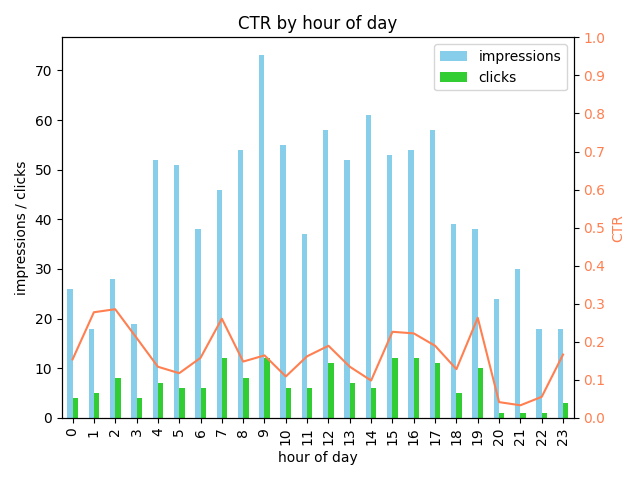

In [5]:
import numpy as np
# First create a subplot and add clicks vs. impressions as bar chart
fig, axes = plt.subplots()
axes = grouped_xdf.plot(
    ax=axes,
    kind='bar',
    title="CTR by hour of day",
    x=('hour',''),
    y=[('click', 'count'),('click','sum')],
    color=['skyblue', 'limegreen'],
    stacked=False,
    fill=True
)
# instantiate a second axes that shares the same x-axis
# so that we can add a scaled version of our ctr on top of that graph
ctr_ax = axes.twinx()

# set labels accordingly for our legend
axes.set_xlabel('hour of day')
axes.set_ylabel('impressions / clicks')
axes.legend(['impressions', 'clicks'])

# select x and y axis for our ctr line chart
x=grouped_xdf[('hour','')]
ctr = grouped_xdf[('click', 'mean')]

# select a color, scale, etc. for our ctr line chart
color = 'coral'
ctr_ax.set_ylim(bottom=0.0, top=1.0)
ctr_ax.set_ylabel('CTR', color=color)
# plot ctr on top of our chart
ctr_ax.plot(x, ctr, color=color)
# beautify our ctr a bit to improve comprehension
ctr_ax.yaxis.set_ticks(np.arange(0, 1.1, step=0.1))
ctr_ax.tick_params(axis='y', labelcolor=color)
# tighten layout, otherwise the right y-label is slightly clipped
fig.tight_layout()

# Outlier Detection

### Calculating an SMA

Below code provides the possibility to detect outliers by using one of two moving averages, namely an 
* SMA with varying windows sizes - for a generic detection
* EMA with varying windows sizes - for a detection more resilient against change over time
Either way we will stick to exactly one, due to time constraints.

#### Possible outlook not covered right now
Introduce multiple subplots and enable calculating more than one moving average with different window sizes and
plot them all.

> NOTE!
> As neither the provided challenge material, nor the challenge at kaggle (https://www.kaggle.com/c/avazu-ctr-prediction) provided enough information to disambiguously imply the intended purpose of this analysis, we will base further steps on a few assumptions:
> We will aggregate daily_ctr on a daily basis, so we have a measurable base datapoint, which
>   * a) changes daily
>   * b) is probably different of a moving average (rectifying looking for outliers)
>   * c) the difference between those two expected values could be of value, as a moving average is a more robust mean and the comparison of such could lead to educated conclusions w.r.t. to certain business cases
> 
> This should lead to a nice showcase and also have quite a bit of a value for further analysis and interpretation

In [6]:
verbose and print(f'Original dataframe')
verbose and display(xdf)

sma_window_sizes=[5]
ema_window_sizes=[]

std_factor=1.5

# Sorting by datetime (as we want to calculate the moving average chronologically)
print('Sorting dataframe by `hours`')
xdf = xdf.sort_values(by=['hour'])

# set up our comparison column name we want to use throughout this cell
comp_col_name = 'daily_ctr'

xdf = (xdf.groupby(by=[xdf.hour.map(lambda h: h.date())]) # group by date (strip time)
               .agg('mean') # aggregate the mean (i.e. ctr)
               .reset_index() # flatten column indexes
               .rename(columns = {'click': comp_col_name}, inplace = False)) # replace click by our comparison column
# quick sanity check
display(xdf.head())

# prepare functions for adding different moving averages to the dataframe, as well as adding the differences of such
# to our comparison column and one for outlier detection

def addMAs(df, col_name, sma_window_sizes=[], ema_window_sizes=[]):
    '''
    Calculates Simple/Exponential Moving Average w/ varying windows sizes and adds them to the dataframe
    '''
    for ws in sma_window_sizes:
        print(f'Calculating SMA({ws}) ...')
        df[f'SMA({ws})'] = df[col_name].rolling(ws).mean()

    # calculating Exponential Moving Average w/ varying windows sizes
    for ws in ema_window_sizes:
        print(f'Calculating EMA({ws}) ...')
        df[f'EMA({ws})'] = df[col_name].ewm(span=ws, adjust=True).mean()
    verbose and display(df.head(50))
    return df


def addDiff(df, colA, colB):
    '''
    Calculates the abssolute difference of two columns abs(colA - colB) into `diff(<colA>,<colB>)` column
    and adds it to the dataframe
    '''
    df[f'diff({colA},{colB})'] = abs(df[colA] - df[colB])
    return df

def calc_std(df, col_name, verbose=True):
    '''
    Computes standard deviation of a specific column within provided dataframe 
    '''
    std_name = f'σ<sub>{col_name}</sub>'
    verbose and display(HTML(f'Calculating standard deviation {std_name}'))
    std = df[col_name].std()
    verbose and display(HTML(f'{std_name} = {std}'))
    return std

def detectOutlier(df, diff_col, candidate_col, std_factor=1.0, verbose=True):
    '''
    Adds a new column 'outliers' to the dataframe,
    where cell is
        value of `candidate_col` if `diff_col` > `std_factor` * `std`
        NaN otherwise
    
    Parameters:
        df the dataframe containing below columns
        candidate_col is the column containing the to be bypassed value (like daily_ctr)
        diff_col data frame column to be compared against candidate_col
        std_factor standard deviation factor which is used for calculating our outlier threshold
        verbose Outputs additional information for calculation of the standard deviation
    Return:
         df incl. 'outliers' column
        
    '''
    # calculate standard deviation
    std = calc_std(df, comp_col_name, verbose=verbose)
    verbose and display(HTML(f'{std_factor} × σ<sub>{comp_col_name}</sub> = {std*std_factor}'))

    # add outlier column to dataframe
    df['outlier'] = np.where(df[diff_col] > (std_factor * std), df[candidate_col], np.nan)
    return df

# column names for all moving averages to be computed
calculated_MAs = [f'SMA({ws})' for ws in sma_window_sizes] + [f'EMA({ws})' for ws in ema_window_sizes]
# the one moving average column we'd like to use for our detection
picked_MA=calculated_MAs[0]
# the resulting difference column's name for our computed difference
picked_diff = f'diff({comp_col_name},{picked_MA})'

# Some additional information for the user
display(HTML(f'''
<b>Processing...</b>
    <ul>
    <li>calculating {calculated_MAs}</li>
    <li>difference {picked_MA}</li>
    <li>detect outliers by abs diff</li>
    </ul>
'''))
# Mixing everything together :)
xdf = (
    xdf.pipe(addMAs, sma_window_sizes=sma_window_sizes, col_name=comp_col_name)
       .pipe(addDiff, colA=comp_col_name, colB=picked_MA)
       .pipe(detectOutlier, diff_col=picked_diff, candidate_col=comp_col_name, std_factor=std_factor)
)

# sanity check
display(xdf)

Sorting dataframe by `hours`


,hour,daily_ctr
0,2014-10-21,0.191489
1,2014-10-22,0.110294
2,2014-10-23,0.173077
3,2014-10-24,0.164835
4,2014-10-25,0.159091


Calculating SMA(5) ...


,hour,daily_ctr,SMA(5),"diff(daily_ctr,SMA(5))",outlier
0,2014-10-21,0.191489,NaN,NaN,NaN
1,2014-10-22,0.110294,NaN,NaN,NaN
2,2014-10-23,0.173077,NaN,NaN,NaN
3,2014-10-24,0.164835,NaN,NaN,NaN
4,2014-10-25,0.159091,0.159757,0.000666,NaN
5,2014-10-26,0.232558,0.167971,0.064587,0.232558
6,2014-10-27,0.202899,0.186492,0.016407,NaN
7,2014-10-28,0.183333,0.188543,0.005210,NaN
8,2014-10-29,0.112150,0.178006,0.065857,0.112150
9,2014-10-30,0.152381,0.176664,0.024283,NaN


<IPython.core.display.Javascript object>


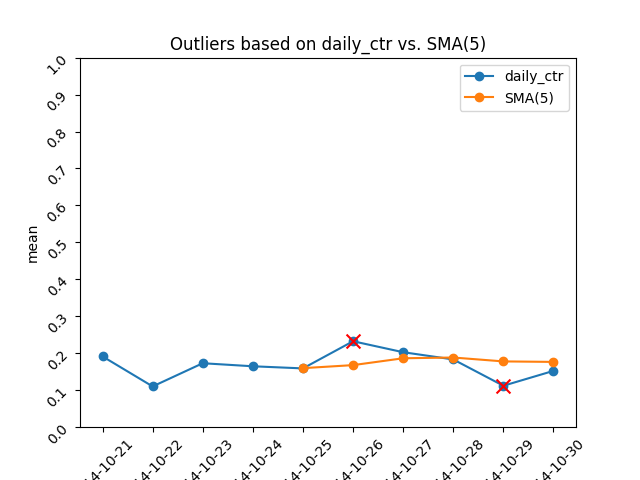

In [7]:
import numpy as np

# plot our daily_ctr and picked moving average
fig, axes = plt.subplots()
axes = xdf.plot(
    ax=axes,
    kind='line',
    marker='o',
    title=f'Outliers based on {comp_col_name} vs. {picked_MA}',
    x='hour',
    y=[comp_col_name] + calculated_MAs,
    stacked=False,
    zorder=0
)

# sprinkle it with our found outliers
axes.scatter(x=xdf['hour'],
             y=xdf['outlier'],
             marker='x',
             color='red',
             s=100,
             zorder=1)
# beautify it for better comprehension
axes.tick_params(labelrotation=45)
axes.set_xlabel('time')
axes.set_ylabel('mean')
axes.yaxis.set_ticks(np.arange(0, 1.1, step=0.1))

fig.show()